# Tutorial 1: Creating and Solving Factor Graphs
In this tutorial you will learn how to create, solve, and explore factor graphs, as well as what variables, factors, and priors are.

## What is a Factor Graph

Wikipedia tells us a factor graph is a bipartite graph representing the factorization of a function.
 
If you haven't taken some advanced statistics classes you are probably wondering: Bipartite graph? Factorization? I just want to navigate my robot.
For robotics, factor graphs are the common language used to describe your robot's estimation problem (the function) in a way both humans and computers can understand. 
The estimation problem can be anything from robot localization, structure from motion, calibration to full SLAM with parametric or non-parametric measurements and beliefs.
A factor graph is a graphical model with two types of nodes, variables and factors, connected by edges between the variables and factors (bipartite graph). 
Variables represent the unknown random variables in the estimation problem, such as vehicle or landmark positions, sensor calibration parameters, and more.
Factors represent the algebraic interaction between particular variables using stochastic models, for example wheel odometry between poses, which is depicted with edges. 
A graph of variables and factors is the factorization of the function describing your system, and effectively represents a breakdown of the complex problem describing your robot navigation; 
for example, the graph models the position and orientation (pose) of your robot at any given time relative to landmarks. 
This factorization allows us to solve the optimization (a.k.a. inference) problem for all variables given every measurement described by the factors.
See Caesar.jl docs [Graph Concepts](https://juliarobotics.org/Caesar.jl/latest/concepts/concepts/#Graph-Concepts) for more detail.

### Let's build a factor graph

First, we will need some packages: 
- `GraphPlot` - for visualizing graphs.
- `DistributedFactorGraphs` - standardized API for interacting with factor graphs.
- `IncrementalInference` - Optimization routines for incremental non-parametric and parametric solutions based on factor graphs.
- `RoME` - Robot Motion Estimate: Tools, Variables, and Factors for SLAM in robotics.

In [65]:
# suppress unnecessary printouts in the notebook
using Logging
Logging.disable_logging(Logging.Warn)
# to enable set logging level to allow above debug
# Logging.disable_logging(Logging.Debug)

LogLevel(1001)

In [66]:
using GraphPlot
using DistributedFactorGraphs
using IncrementalInference
using RoME

To create a new factor graph with default settings use the `initfg()` function. 

In [67]:
fg = initfg();

## Variables and Factors 

Variables, denoted as the larger nodes in the figure below, represent state variables of interest such as vehicle or landmark positions, sensor calibration parameters, and more. Variables are likely hidden values that are not directly observed, but we want to estimate them from observed data and at least some minimal algebra structure from probabilistic measurement models.

Factors, the smaller nodes in the figure below, represent the algebraic interaction between particular variables, which is captured through edges. Factors must adhere to the limits of probabilistic models – for example conditional likelihoods capture the likelihood correlations between variables; while priors (unary to one variable) represent absolute information to be introduced. 

`RoME` provides variables and factors useful to robotics.
We start with a `Pose2` variable, i.e. position and orientation in two dimensions.
To add variables to our factor graph, `fg`, we created above, call `addVariable` with a label `x0` and type `Pose2`


In [68]:
addVariable!(fg, :x0, Pose2);

We now have a factor graph with one variable, but to solve it we need some additional information. 
In this example, we need the estimated starting point of our robot.
We use unary factors called priors to represent absolute information to be introduced. 
In this case we use `PriorPose2`, as our variable type is also `Pose2`.
Since factors represent a probabilistic interaction between variables, we need to specify the distribution our factor will represent. Here we use `MvNormal` which is a [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) from [Distributions.jl](https://github.com/JuliaStats/Distributions.jl). 

Let's create a `PriorPose2` unary factor with zero mean and a covariance matrix of (`diagm([0.05,0.05,0.01].^2)`):

$\Sigma = \begin{bmatrix} 0.0025 & 0.0 &  0.0 \\ 0.0 & 0.0025 & 0.0 \\ 0.0 &  0.0 &  0.0001 \end{bmatrix}$



In [69]:
prior_distribution = MvNormal(zeros(3), diagm([0.05,0.05,0.01].^2))
addFactor!(fg, [:x0], PriorPose2(prior_distribution)) 

DFGFactor{CommonConvWrapper{PriorPose2...}}
  timestamp:     2022-03-26T10:09:22.142+02:00
   nstime:       0 nanoseconds
  label:         x0f1
  solvable:      1
  VariableOrder: [:x0]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: PriorPose2{FullNormal}
Z:
FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [0.0025 0.0 0.0; 0.0 0.0025 0.0; 0.0 0.0 0.0001]
)



We can look at the factor graph we have so far using `plotDFG`.

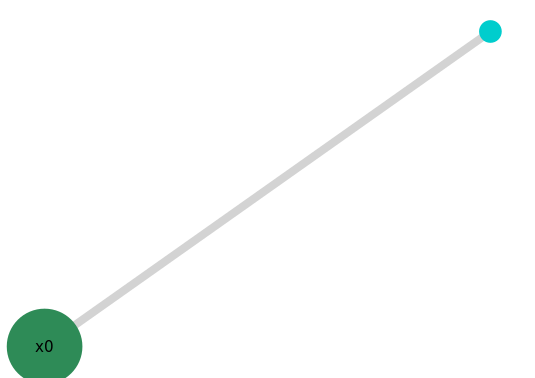

In [70]:
plotDFG(fg)

The prior is now connected to the variable, `x0`, but it is not initialized yet. Automatic initialization of variables depends on how the factor graph model is constructed. This tutorial demonstrates this behavior by first showing that `x0` is not initialized:

In [71]:
isInitialized(fg, :x0)

false

**Graph-based Initialization**

Why is `x0` not initialized? Since no other variable nodes have been 'connected to' (or depend) on `x0` and future intentions of the user are unknown, the initialization of `x0` is deferred until the latest possible moment. `IncrementalInference.jl` assumes that the user will generally populate new variable nodes with most of the associated factors before moving to the next variable. By delaying initialization of a new variable (say `x0`) until a second newer uninitialized variable (say `x1`) depends on `x0`, the `IncrementalInference` algorithms hope to then initialize `x0` with the more information from previous and surrounding variables and factors. Also, note that initialization of variables is a local operation based only on the neighboring nodes – global inference over the entire graph is shown later in this tutorial.

**Robot Odometry - Relative Factor**

Next, we want to add an odometry factor that connects our two robot poses `x0` and `x1` together to form a chain.
Here we use a relative factor of type `Pose2Pose2` with a measurement from pose `x0` to `x1` of (x=1.0,y=0.0,θ=pi/2); the robot drove 1 unit forward (in the x direction).
Similarly to the prior we added above, we use an `NvNormal` distribution to represent the odometry with mean and covariance:

$\mu =(x=1, y=0, \theta=\frac{\pi}{2})$

$\Sigma = \begin{bmatrix} 0.01 & 0.0 &  0.0 \\ 0.0 & 0.01 & 0.0 \\ 0.0 &  0.0 &  0.0001 \end{bmatrix}$


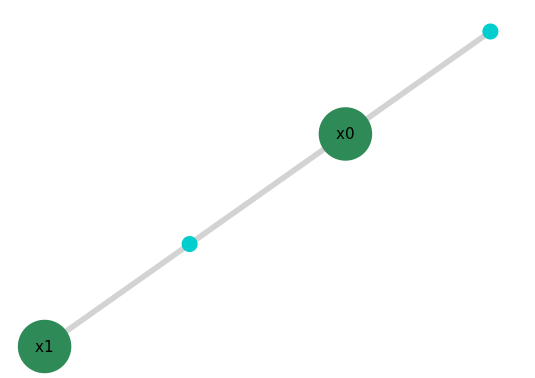

In [72]:
addVariable!(fg, :x1, Pose2);
odo_distribution = MvNormal([1.0, 0.0, pi/2], diagm([0.1, 0.1, 0.01].^2))
fac_1 = addFactor!(fg, [:x0, :x1], Pose2Pose2(odo_distribution))

plotDFG(fg)

By adding `x1` and connecting it with a factor to `x0` the automatic initialization of `x0` is triggered. 
Note that the automatic initialization of `x0` is aware that `x1` is not initialized and therefore only used the prior unary factor to initialize the marginal belief estimate for `x0`. The structure of the graph has now been updated to two variable nodes and two factors.

In [73]:
isInitialized(fg, :x0)

true

### Solving

We now have a graph we can solve using the Multi-Modal iSAM (MM-iSAM) algorithm. 
The default solver will perform non-parametric inference/state-estimation over our newly created graph.

Fundamentally, inference is performed via the Bayes (junction) tree where Chapman-Kolmogorov transit integral solutions are based on marginal-joint belief estimation (a sum-product / belief-propagation approximation algorithm). Many benefits such as clique recycling are also available. See the [Solving Graphs](https://juliarobotics.org/Caesar.jl/latest/concepts/solving_graphs/) section in the documentation for more detail.

In [74]:
solveGraph!(fg);

Solve Progress: approx max 24, at iter 10 	 Time: 0:00:02

Solve Progress: approx max 24, at iter 11 	 Time: 0:00:02


Building Bayes net...
Find potential functions for each clique


### Results

The RoMEPlotting.jl package allows visualization (plotting) of the belief state over any of the variable nodes.

In [75]:
using RoMEPlotting

[0.002 0.0; 0.0 0.002]
[0.012 0.0; 0.0 0.016]


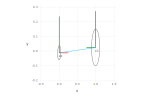

In [76]:
pl = plotSLAM2D(fg, drawContour=false, drawEllipse=true, drawPoints=false)

**What is happening**

The figure shows the position and orientation (red forward) for poses `x0` and `x1`. As well as the covariance ellipse. 
Since the solver used was non-parametric, the covariance ellipse is based on a best Gaussian distribution fit of the full belief.
A few other functions are also handy for interacting with the factor graph, for instance `getVariable` returns the full variable.
Or if you are interested in the suggested Parametric Point Estimate (PPE) use `getPPESuggested`.

In [77]:
var = getVariable(fg, :x1)

DFGVariable{Pose2...}
  manifold:   SpecialEuclidean(2)
  timestamp:  2022-03-26T10:09:22.367+02:00
   nstime:    0 nanoseconds
  label:      x1
  solvable:   1
  tags:       Set([:VARIABLE])
  # VND solveKeys=    (2)
  # initialized:      (true=2,false=0)
  # marginalized:     (true=0,false=2)
    :default <-- VariableNodeData
      initilized:        true
      marginalized:      false
      size bel. samples: (100,)
      kde bandwidths:    0.0273
     VNDs: [:graphinit, :default]
  # PPE solveKeys=    (1)
    :default <-- .suggested:    [0.9936, 0.0238, 1.5711]
  VariableType: Pose2


In [78]:
getPPESuggested(fg, :x1)

3-element Vector{Float64}:
 0.993550483771993
 0.023766512022177975
 1.5711477533056368

**Parametric point estimates and beliefs**

The function `getPPESuggested(fg, :x1)` returns the parametric point estimate for the current belief in variable `x1`.
A PPE can be the maximum or mean of the belief. 
If the belief is a normal distribution, both correspond with its mean. 
However, care should be taken with using PPEs when beliefs might be non-parametric, for example, in a multimodal belief with two peaks, max corresponds with the maximum of the two peaks while the mean will fall somewhere in between them. 
In non-parametric cases, it is better to work with the full belief obtained by the Kernel Density Estimate (KDE).  
Kernel Density Estimation is a non-parametric way to estimate the probability density function of a random variable.
With the default solver, a full probability density function is always available and can be visualized using `plotKDE`.
Non-parametric solutions will be discussed in more detail in tutorial 2. We only show the plot for variable `x1` here.




Multiple planes stacked into Compose.Context, use Gadfly.draw(PNG(file.png,10cm,10cm),plothdl). Or PDF.
KDEPlotting01.jl/drawAllPairs -- supressing all exceptions for stacking empty contour plotsUndefRefError()


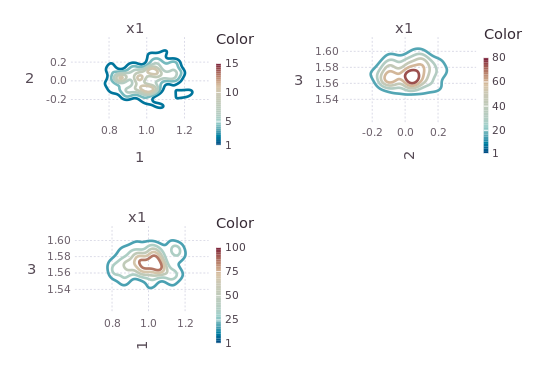

In [79]:
plotKDE(fg, :x1)

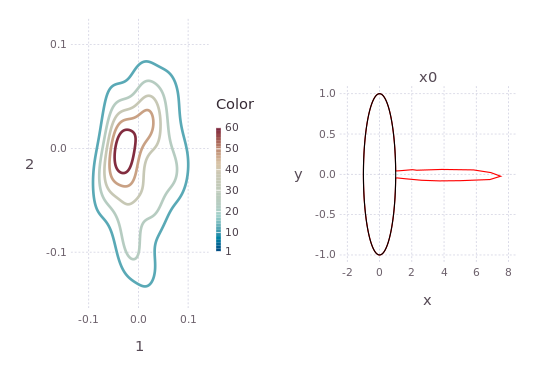

In [80]:
plotPose(fg, :x0)

See the [section on Plotting in the Caesar docs](https://juliarobotics.org/Caesar.jl/latest/concepts/2d_plotting/) for more detail.

### Adding more poses and a point landmark

So far we worked with the `Pose2` factor type. 
Among others, `RoME` also provides the `Point2` variable type and `Pose2Point2BearingRange` factor, which we will use to represent a landmark sighting in our factor graph.
We will add a landmark `l1` with bearing range measuremet of bearing=$(\mu=0,\sigma=0.03)$ range=$(\mu=0.5,\sigma=0.1)$ and continue our robot trajectory by driving around in a square.

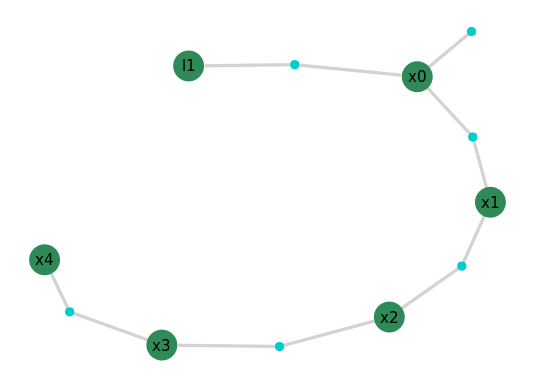

In [81]:

addVariable!(fg, :l1, Point2)

p2br = Pose2Point2BearingRange(Normal(0.0,0.03),Normal(0.5,0.1))
addFactor!(fg, [:x0,:l1], p2br)

addVariable!(fg, :x2, Pose2)
addFactor!(fg, [:x1,:x2], Pose2Pose2(odo_distribution))

addVariable!(fg, :x3, Pose2)
addFactor!(fg, [:x2,:x3], Pose2Pose2(odo_distribution))

addVariable!(fg, :x4, Pose2)
addFactor!(fg, [:x3,:x4], Pose2Pose2(odo_distribution))

plotDFG(fg)

We now have a longer odometry chain with one landmark sighting, let's solve the factor graph again so we can have a look at the results.

In [82]:
solveGraph!(fg)

Building Bayes net...
Find potential functions for each clique


MetaBayesTree
  Nr cliques:  4


[0.002 -0.0; -0.0 0.002]
[0.01 0.0; 0.0 0.008]
[0.022 -0.001; -0.001 0.012]
[0.034 -0.005; -0.005 0.016]
[0.047 -0.003; -0.003 0.027]
[0.01 -0.0; -0.0 0.002]


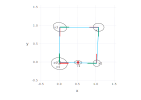

In [83]:
pl = plotSLAM2D(fg, drawContour=false, drawEllipse=true, drawPoints=false)

As expected, the robot continued its square trajectory to end off where it started. 
To illustrate a loop closure, we add another bearing range sighting to from pose `x4` to landmark `l1`, solve the graph and plot the new results: 

Solve Progress: approx max 96, at iter 13 	 Time: 0:00:03

Solve Progress: approx max 96, at iter 17 	 Time: 0:00:06

Solve Progress: approx max 96, at iter 22 	 Time: 0:00:09

Solve Progress: approx max 96, at iter 29 	 Time: 0:00:11

Solve Progress: approx max 96, at iter 39 	 Time: 0:00:12Solve Progress: approx max 96, at iter 40 	 Time: 0:00:12Solve Progress: approx max 96, at iter 41 	 Time: 0:00:12

Solve Progress: approx max 96, at iter 47 	 Time: 0:00:13


Building Bayes net...
Find potential functions for each clique
[0.005 0.0; 0.0 0.002]
[0.013 -0.002; -0.002 0.01]
[0.02 -0.006; -0.006 0.019]
[0.026 -0.004; -0.004 0.013]
[0.025 0.003; 0.003 0.026]
[0.008 -0.001; -0.001 0.002]


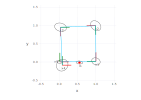

In [84]:
p2br = Pose2Point2BearingRange(Normal(0.0,0.03),Normal(0.5,0.1))
addFactor!(fg, [:x4,:l1], p2br)

solveGraph!(fg)
pl = plotSLAM2D(fg, drawContour=false, drawEllipse=true, drawPoints=false)

## Next Steps

Tutorial 2 will give an introduction to non-parametric solutions.

## Additional Resources

### Variable representation and factor algebraic operations

The variables used in this tutiorail, `Point2` and `Pose2`, are represented as points on manifolds and all algebraic operations, inference/optimization are also performed on manifold.
For more information on how manifolds are used in Ceaser.jl, refer to the [manifold section in the documentation](https://juliarobotics.org/Caesar.jl/latest/concepts/using_manifolds/).

### Custom Variables and Factors

In most scenarios, the existing variables and factors should be sufficient for most robotics applications. 
Caesar however, is extensible and allows you to easily incorporate your own variable and factor types for specialized applications.

Have a look at the Caesar documentaton if you are interested in creating custom vairables, factors (or priors)

- [Custom variables](https://juliarobotics.org/Caesar.jl/latest/examples/custom_variables/)
- [Custom prior factors](https://juliarobotics.org/Caesar.jl/latest/examples/basic_definingfactors/)
- [Custom relative factors](https://juliarobotics.org/Caesar.jl/latest/examples/custom_relative_factors/)


### Bayes (Junction) Tree

Inference is performed on the bayes tree see: [Bayes tree principles](https://juliarobotics.org/Caesar.jl/latest/principles/bayestreePrinciples/)